# **Redis + Feast**: Feature Store Setup on Google Cloud Platform (GCP)

The purpose of this notebook environment is to allow you to explore Feast, Redis, and GCP components all from one place.


![architecture](img/Feast_GCP_Redis_Ray_Demo.png)

## Install Dependencies

Pip install the feature_store package to use the provided tools.

In [5]:
!pip install -U .

Processing /home/jovyan/work
  Preparing metadata (setup.py) ... done
  Using cached feast-0.22.0-cp310-cp310-linux_aarch64.whl
  Using cached ipython-7.34.0-py3-none-any.whl (793 kB)
  Using cached tensorflow_metadata-1.10.0-py3-none-any.whl (50 kB)
  Using cached google_api_core-2.10.2-py3-none-any.whl (115 kB)
  Using cached fastavro-1.6.1-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (2.6 MB)
  Using cached tabulate-0.8.10-py3-none-any.whl (29 kB)
  Using cached mmh3-3.0.0.tar.gz (10 kB)
  Preparing metadata (setup.py) ... done
  Using cached pandas-1.5.1-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (11.4 MB)
  Using cached bowler-0.9.0-py3-none-any.whl (36 kB)
  Using cached grpcio_reflection-1.50.0-py3-none-any.whl (20 kB)
  Using cached dill-0.3.5.1-py2.py3-none-any.whl (95 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached proto_plus-1.20.6-py3-none-any.whl (46 kB)
  Using cached PyYAML-6.0-cp310-cp310-manylinux_2_17_aarch6

**After running this cells, you may need to restart the runtime to continue** (Runtime > Restart runtime.)

# Fetching Historical Data

Now that our Feast feature store has been provisioned and GCP infra is ready to go, we can use Feast to generate a training dataset. To do this, we need an entity dataframe, alongside the list of features we want.

To make things simpler, we use the [`DataFetcher`](utils/data_fetcher.py) class that wraps Feast.

In [1]:
from feature_store.repo import config
from feature_store.utils import (
    DataFetcher,
    ModelRepo,
    storage
)

# Load fs
fs = storage.get_feature_store(
    config_path=config.REPO_CONFIG,
    bucket_name=config.BUCKET_NAME
)

# Load data fetcher
data_fetcher = DataFetcher(fs)

ModuleNotFoundError: No module named 'pandas'

In [4]:
# Fetch Historical Training Data
ds = data_fetcher.get_training_data(
    entity_query=f"""
        select
            state,
            date as event_timestamp
        from
            {config.BIGQUERY_DATASET_NAME}.{config.WEEKLY_VACCINATIONS_TABLE}
    """
)

# Clean up any nulls
ds.dropna(inplace=True)
ds.sort_values(['event_timestamp', 'state'], axis=0, inplace=True)

In [5]:
virginia = ds[ds.state == 'Virginia']

In [6]:
virginia.head()

,state,event_timestamp,lag_1_vaccine_interest,lag_2_vaccine_interest,lag_1_vaccine_intent,lag_2_vaccine_intent,lag_1_vaccine_safety,lag_2_vaccine_safety,lag_1_weekly_vaccinations_count,lag_2_weekly_vaccinations_count,weekly_vaccinations_count
2770,Virginia,2021-01-25 00:00:00+00:00,62.549712,64.178025,22.662099,25.802051,9.102064,8.580120,152933,115553.0,329892.0
2840,Virginia,2021-02-01 00:00:00+00:00,59.771108,62.549712,23.881589,22.662099,9.060282,9.102064,329892,152933.0,278811.0
2839,Virginia,2021-02-08 00:00:00+00:00,71.490393,59.771108,35.214495,23.881589,11.884993,9.060282,278811,329892.0,266744.0
2773,Virginia,2021-02-15 00:00:00+00:00,67.818582,71.490393,34.463701,35.214495,12.675395,11.884993,266744,278811.0,318139.0
2822,Virginia,2021-02-22 00:00:00+00:00,72.135382,67.818582,34.295162,34.463701,14.205749,12.675395,318139,266744.0,344859.0


In [7]:
virginia.tail()

,state,event_timestamp,lag_1_vaccine_interest,lag_2_vaccine_interest,lag_1_vaccine_intent,lag_2_vaccine_intent,lag_1_vaccine_safety,lag_2_vaccine_safety,lag_1_weekly_vaccinations_count,lag_2_weekly_vaccinations_count,weekly_vaccinations_count
2788,Virginia,2022-09-12 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,40297,55661.0,93861.0
2785,Virginia,2022-09-19 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,93861,40297.0,119960.0
2778,Virginia,2022-09-26 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,119960,93861.0,132883.0
2794,Virginia,2022-10-03 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,132883,119960.0,147406.0
2805,Virginia,2022-10-10 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,147406,132883.0,43433.0


In [8]:
virginia.weekly_vaccinations_count.describe()

count        90.000000
mean     195566.522222
std      154582.415775
min       16943.000000
25%       79666.750000
50%      145087.500000
75%      291563.250000
max      644252.000000
Name: weekly_vaccinations_count, dtype: float64

<AxesSubplot: xlabel='lag_2_vaccine_interest', ylabel='weekly_vaccinations_count'>

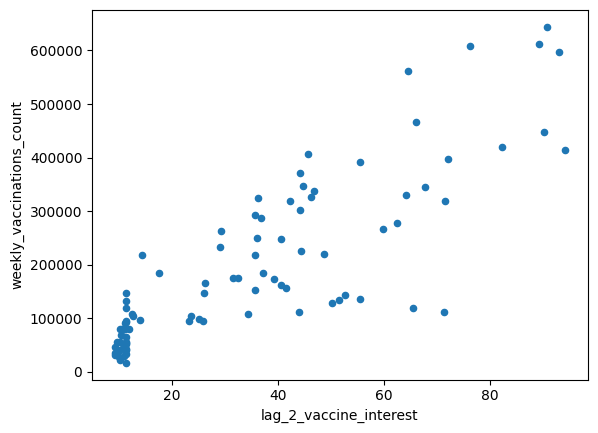

In [9]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_interest')

<AxesSubplot: xlabel='lag_2_vaccine_safety', ylabel='weekly_vaccinations_count'>

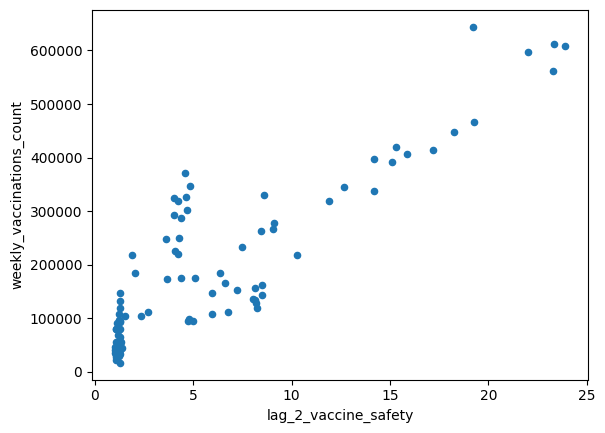

In [10]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_safety')

<AxesSubplot: xlabel='lag_2_vaccine_intent', ylabel='weekly_vaccinations_count'>

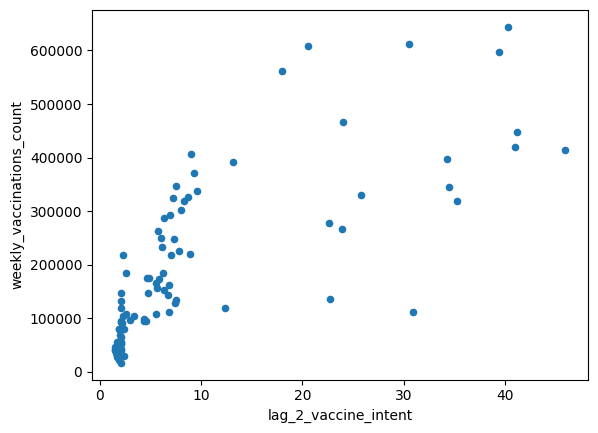

In [11]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_intent')

<AxesSubplot: xlabel='lag_1_weekly_vaccinations_count', ylabel='weekly_vaccinations_count'>

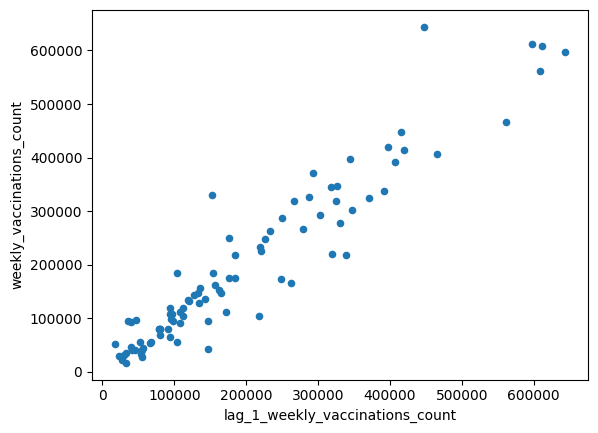

In [13]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_1_weekly_vaccinations_count')

## Training a model

Now, we can use our features to train a model:

In [1]:
from train.main import train_validate
from matplotlib import pyplot

In [2]:
features = [
    "state",
    "lag_1_vaccine_interest",
    "lag_2_vaccine_interest",
    "lag_1_vaccine_intent",
    "lag_2_vaccine_intent",
    "lag_1_vaccine_safety",
    "lag_2_vaccine_safety",
    "lag_1_weekly_vaccinations_count",
    "lag_2_weekly_vaccinations_count"
]

# Train!
columns = ["event_timestamp"] + features + ["weekly_vaccinations_count"]
mae, y, yhat, model = train_validate(
    ds[columns],
    n_test_weeks=1,
    timestamp_column="event_timestamp"
)


# plot expected vs preducted
print('MAE: %.3f' % mae)
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

NameError: name 'ds' is not defined

In [ ]:
# Explore feature importance
for feature, imp in zip(features, model[-1].feature_importances_):
    print(feature, imp)

## Saving and deploying the model

First we save the model to storage.

In [ ]:
# Use the model repo helper class
host, port = config.REDIS_CONNECTION_STRING.split(":")
model_repo = ModelRepo(host, port, config.REDIS_CONNECTION_STRING, "vaccine_demand")
model_repo.setup()

In [ ]:
# Save model

version = await model_repo.save_version(model)
print(f"Saved model version {version}")

# Low latency inference

To make a prediction in real-time, we need to do the following:

1. Fetch our features from Redis using the Feast client
2. Pass these features to our model
3. Return these predictions to the user

![Feast landing page, blog post - [Archive].png](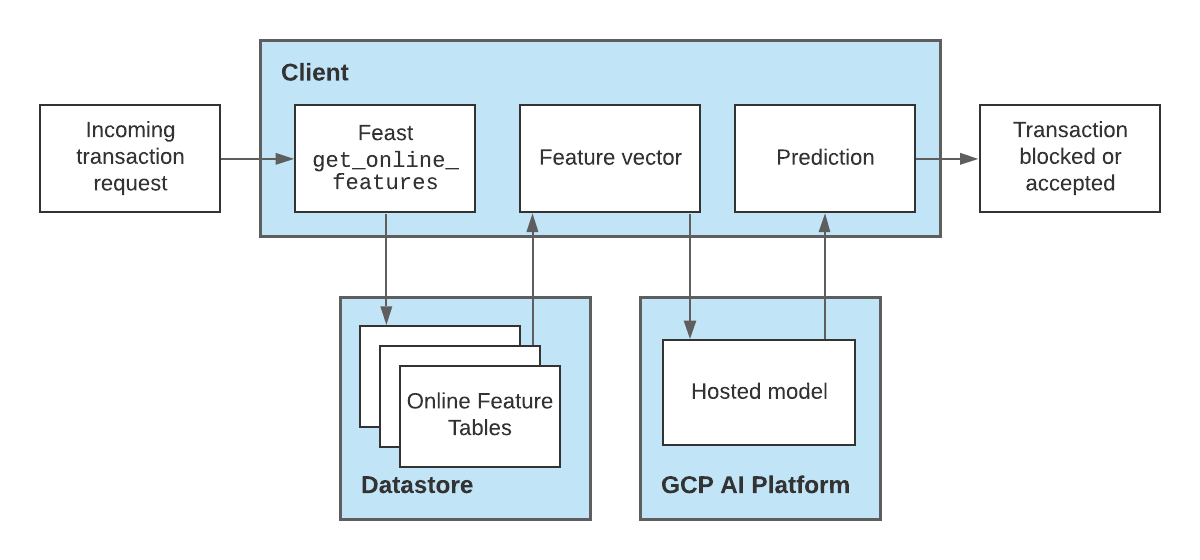)


In [ ]:
# Fetch online feature
online_feature = data_fetcher.get_online_data({"state": "Virginia"})

In [ ]:
# Test the vaccine demand
from serve.vaccine_demand import VaccineDemand

vaccine_demand = VaccineDemand(model, repo_config, cols=features)

## Trouble Shooting


### Configure BigQuery permissions

You might also need to give your cloud function permission to access your BigQuery dataset. To do this:

1. Open your dataset in BigQuery.
2. Hover over the plus icon, and click "share dataset."
3. In the pop-up, enter your project's service account email. This should be `[PROJECT_ID]@appspot.gserviceaccount.com`. 
4. Select permission "Can Edit" and confirm.

## Run the workflow

If you want to test the workflow manually:

1. Open the **Cloud Scheduler** page in the console.
2. Click the ‘Run Now’ button in the feast-daily-job row.
3. Open the **Cloud Function** page in the console.
4. Open your **Cloud Function** (feast-update-features.)
5. Open the Logs tab to see the latest run of your cloud function.

# Next steps

We have just built an end-to-end system using Feast and Redis Enterprise in GCP.


This system generates realtime predictions using up to date feature values from our model.

Next steps that you can take after completing this tutorial include:

- Check your repo into git to enable collaboration with your team.
- Use this tutorial to bootstrap a model for your use case by editing features / model.
- Incorporate the code in this tutorial into your company's batch pipelines by creating stages that perform feature creation and materialization.

# Cleanup

If you want to clean up the resources created during this tutorial, run the following cells:


In [15]:
! ./teardown.sh

Waiting for operation to finish...done.                                        
Deleted [projects/nifty-time-353221/locations/us-central1/functions/feast-update-features].
ERROR: (gcloud.scheduler.jobs.delete) Please use the location flag to manually specify a location.
Tearing down Feast infrastructure
Tearing down feature store


In [ ]:
! echo $config.PROJECT_ID'.'$config.BIGQUERY_DATASET_NAME